In [1]:
%%capture
!pip install "cvxpy[OSQP]"

!git clone https://github.com/shaoanlu/pyNMPC.git
%cd pyNMPC

In [2]:
from pyNMPC.nmpc import NMPC, MPCParams, MPCResult

In [3]:
def dynamics(x, u, dt):
    """Unicycle dynamics model."""
    theta = x[2]
    return x.at[0].set(x[0] + u[0] * jnp.cos(theta) * dt) \
            .at[1].set(x[1] + u[0] * jnp.sin(theta) * dt) \
            .at[2].set(x[2] + u[1] * dt)

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import time
from tqdm import tqdm
from typing import List, Tuple, Optional, Dict, Any
from IPython.display import HTML


class SimulationResults:
    """Container for closed-loop simulation results."""
    def __init__(self):
        self.states = []       # List of states [x, y, theta]
        self.controls = []     # List of controls [v, omega]
        self.mpc_results = []  # List of MPC results at each timestep
        self.references = []   # List of reference states
        self.timestamps = []   # List of timesteps
        self.computation_times = []  # List of MPC computation times

    def add_step(self, state: np.ndarray, control: np.ndarray, mpc_result: MPCResult,
                 reference: np.ndarray, timestamp: float, computation_time: float):
        """Add a simulation step to the results."""
        self.states.append(state.copy())
        self.controls.append(control.copy())
        self.mpc_results.append(mpc_result)
        self.references.append(reference.copy())
        self.timestamps.append(timestamp)
        self.computation_times.append(computation_time)

    def get_arrays(self):
        """Convert lists to numpy arrays for easier plotting."""
        return {
            'states': np.array(self.states),
            'controls': np.array(self.controls),
            'references': np.array(self.references),
            'timestamps': np.array(self.timestamps),
            'computation_times': np.array(self.computation_times)
        }


def run_closed_loop_simulation(
    x0: jnp.ndarray,
    reference_trajectory: List[jnp.ndarray],
    params: MPCParams,
    sim_time: float = 10.0,
    controller_dt: float = 0.1,
    sim_dt: Optional[float] = None
) -> SimulationResults:
    """
    Run a closed-loop simulation of the unicycle model with MPC control.

    Args:
        x0: Initial state [x, y, theta]
        reference_trajectory: List of reference states for each timestep
        params: MPC parameters
        sim_time: Total simulation time
        controller_dt: Control update interval
        sim_dt: Simulation timestep (defaults to controller_dt if None)

    Returns:
        SimulationResults object with simulation data
    """
    # Use controller_dt for simulation if sim_dt is not specified
    sim_dt = sim_dt or controller_dt

    # Initialize simulation variables
    current_state = x0.copy()
    current_time = 0.0
    results = SimulationResults()

    # Store the initial state
    # Initial control is [0, 0] and initial MPC result is None
    results.add_step(
        current_state,
        jnp.zeros(2),
        None,
        reference_trajectory[0],
        current_time,
        0.0
    )

    # Control update counter and timing
    control_update_time = 0.0
    current_control = jnp.zeros(2)
    mpc_result = None
    latest_mpc_result = None

    # Create cvxpy problem
    mpc = NMPC(dynamics_fn=dynamics, params=params)

    # Main simulation loop with tqdm
    pbar = tqdm(total=int(sim_time / sim_dt), desc="Simulation Progress", ncols=100)

    # Main simulation loop
    while current_time < sim_time:
        # Update control if it's time (control updates happen at intervals of controller_dt)
        if abs(current_time - control_update_time) < 1e-6 or current_time > control_update_time:
            # Get the closest reference point
            ref_idx = min(int(current_time / controller_dt), len(reference_trajectory) - 1)
            current_reference = reference_trajectory[ref_idx]
            current_reference = current_reference.at[2].set(np.unwrap([current_state[2], current_reference[2]])[1])

            # Run MPC
            start_time = time.time()
            mpc_result = mpc.solve(x0=current_state, x_ref=current_reference, mpc_result=mpc_result)
            computation_time = time.time() - start_time

            # Extract the first control action
            current_control = mpc_result.u_traj[0]
            latest_mpc_result = mpc_result

            # Update next control update time
            control_update_time = current_time + controller_dt

        # Apply control to the system and integrate dynamics
        next_state = dynamics(current_state, current_control, sim_dt)

        # Update simulation time and state
        current_time += sim_dt
        current_state = next_state

        # Store results
        results.add_step(
            current_state,
            current_control,
            latest_mpc_result,
            current_reference,
            current_time,
            computation_time if latest_mpc_result else 0.0
        )

        # Update progress bar
        pbar.update(1)
        pbar.set_postfix({
            'Sim Time': f"{current_time:.2f}s",
            'Ctrl Update': f"{control_update_time:.2f}s",
            'MPC Time': f"{computation_time:.3f}s" if latest_mpc_result else 'N/A'
        })

    return results


def draw_unicycle(ax, x, y, theta, size=0.2, color='blue'):
    """
    Draw a unicycle robot representation at a given pose.

    Args:
        ax: Matplotlib axis
        x, y: Position
        theta: Orientation
        size: Size of the robot representation
        color: Color of the robot

    Returns:
        List of artist objects added to the plot
    """
    # Create a triangle to represent the robot
    robot_length = size
    robot_width = size * 0.6

    # Define the triangle points (centered at origin, pointing along x-axis)
    points = np.array([
        [robot_length/2, 0],  # Nose
        [-robot_length/2, robot_width/2],  # Left corner
        [-robot_length/2, -robot_width/2]  # Right corner
    ])

    # Rotate the points
    rot_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    rotated_points = np.dot(points, rot_matrix.T)

    # Translate to the robot's position
    rotated_points[:, 0] += x
    rotated_points[:, 1] += y

    # Create a polygon
    robot = patches.Polygon(rotated_points, closed=True, facecolor=color, alpha=0.7)

    # Add to the plot
    ax.add_patch(robot)

    # Draw orientation line
    line_length = size * 0.8
    end_x = x + line_length * np.cos(theta)
    end_y = y + line_length * np.sin(theta)
    orientation_line = ax.plot([x, end_x], [y, end_y], color='black', linewidth=1.5)[0]

    return [robot, orientation_line]


def plot_simulation_results(results: SimulationResults, plot_mpc_predictions: bool = True,
                           save_path: Optional[str] = None):
    """
    Create a comprehensive visualization of the simulation results.

    Args:
        results: SimulationResults object
        plot_mpc_predictions: Whether to plot MPC prediction trajectories
        save_path: Path to save the figure (optional)
    """
    # Convert results to arrays
    data = results.get_arrays()
    states = data['states']
    controls = data['controls']
    references = data['references']
    timestamps = data['timestamps']

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 3)

    # 1. Trajectory plot (larger plot spanning two rows)
    ax_traj = fig.add_subplot(gs[0:2, 0:2])
    ax_traj.plot(states[:, 0], states[:, 1], 'b-', linewidth=2, label='Actual')
    ax_traj.plot(references[:, 0], references[:, 1], 'r--', linewidth=2, label='Reference')

    # Plot some MPC prediction trajectories at intervals
    if plot_mpc_predictions:
        prediction_interval = max(1, len(results.mpc_results) // 8)
        for i in range(0, len(results.mpc_results), prediction_interval):
            mpc_result = results.mpc_results[i]
            if mpc_result:
                pred_traj = mpc_result.x_traj
                # Plot with transparency
                ax_traj.plot(pred_traj[:, 0], pred_traj[:, 1], 'g-', alpha=0.2, linewidth=1)

    # Mark start and end points
    ax_traj.plot(states[0, 0], states[0, 1], 'go', markersize=8, label='Start')
    ax_traj.plot(states[-1, 0], states[-1, 1], 'ro', markersize=8, label='End')

    # Colorful line based on time progress
    points = np.array([states[:, 0], states[:, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(timestamps.min(), timestamps.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(timestamps)
    lc.set_linewidth(3)
    line = ax_traj.add_collection(lc)
    plt.colorbar(line, ax=ax_traj, label='Time [s]')

    ax_traj.set_xlabel('X position [m]')
    ax_traj.set_ylabel('Y position [m]')
    ax_traj.set_title('Robot Trajectory')
    ax_traj.grid(True)
    ax_traj.axis('equal')
    ax_traj.legend()

    # 2. State evolution over time
    ax_states = fig.add_subplot(gs[0, 2])
    ax_states.plot(timestamps, states[:, 0], 'b-', label='x')
    ax_states.plot(timestamps, states[:, 1], 'g-', label='y')
    ax_states.plot(timestamps, states[:, 2], 'r-', label='θ')
    ax_states.plot(timestamps, references[:, 0], 'b--', alpha=0.5)
    ax_states.plot(timestamps, references[:, 1], 'g--', alpha=0.5)
    ax_states.plot(timestamps, references[:, 2], 'r--', alpha=0.5)
    ax_states.set_xlabel('Time [s]')
    ax_states.set_ylabel('State')
    ax_states.set_title('State Evolution')
    ax_states.grid(True)
    ax_states.legend()

    # 3. Control inputs over time
    ax_controls = fig.add_subplot(gs[1, 2])
    ax_controls.plot(timestamps[:-1], controls[:-1, 0], 'b-', label='v')
    ax_controls.plot(timestamps[:-1], controls[:-1, 1], 'g-', label='ω')
    ax_controls.set_xlabel('Time [s]')
    ax_controls.set_ylabel('Control')
    ax_controls.set_title('Control Inputs')
    ax_controls.grid(True)
    ax_controls.legend()

    # 4. State error over time
    ax_error = fig.add_subplot(gs[2, 0])
    error_x = states[:, 0] - references[:, 0]
    error_y = states[:, 1] - references[:, 1]
    error_theta = np.arctan2(np.sin(states[:, 2] - references[:, 2]),
                           np.cos(states[:, 2] - references[:, 2]))  # Angle difference

    ax_error.plot(timestamps, error_x, 'b-', label='x error')
    ax_error.plot(timestamps, error_y, 'g-', label='y error')
    ax_error.plot(timestamps, error_theta, 'r-', label='θ error')
    ax_error.set_xlabel('Time [s]')
    ax_error.set_ylabel('Error')
    ax_error.set_title('State Error')
    ax_error.grid(True)
    ax_error.legend()

    # 5. Computation time
    ax_compute = fig.add_subplot(gs[2, 1])
    comp_times = np.array(results.computation_times)
    comp_times = comp_times[comp_times > 0]  # Filter out zeros
    ax_compute.plot(comp_times, 'b-')
    ax_compute.set_xlabel('MPC Update')
    ax_compute.set_ylabel('Time [s]')
    ax_compute.set_title('MPC Computation Time')
    ax_compute.grid(True)

    # 6. MPC convergence (iterations)
    ax_conv = fig.add_subplot(gs[2, 2])
    sqp_iters = [result.sqp_iters if result else 0 for result in results.mpc_results]
    sqp_iters = np.array(sqp_iters)
    sqp_iters = sqp_iters[sqp_iters > 0]  # Filter out zeros
    ax_conv.plot(sqp_iters, 'r-')
    ax_conv.set_xlabel('MPC Update')
    ax_conv.set_ylabel('Iterations')
    ax_conv.set_title('SQP Iterations')
    ax_conv.grid(True)

    # Layout adjustments
    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return fig


def create_animation(results: SimulationResults, interval: int = 100,
                    show_predictions: bool = True, save_path: Optional[str] = None):
    """
    Create an animation of the unicycle robot movement.

    Args:
        results: SimulationResults object
        interval: Animation interval in milliseconds
        show_predictions: Whether to show MPC prediction trajectories
        save_path: Path to save the animation (optional)

    Returns:
        Matplotlib animation object
    """
    # Convert results to arrays
    data = results.get_arrays()
    states = data['states']
    references = data['references']

    # Compute plot limits with some margin
    all_x = np.concatenate([states[:, 0], references[:, 0]])
    all_y = np.concatenate([states[:, 1], references[:, 1]])
    x_min, x_max = np.min(all_x) - 1, np.max(all_x) + 1
    y_min, y_max = np.min(all_y) - 1, np.max(all_y) + 1

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title('Unicycle Robot MPC Control')
    ax.grid(True)

    # Plot reference trajectory
    ax.plot(references[:, 0], references[:, 1], 'r--', label='Reference')

    # Initialize plot elements
    robot_artists = []
    traj_line, = ax.plot([], [], 'b-', linewidth=2, label='Actual')
    pred_lines = []

    # Text displays
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    # Drawing the initial state
    draw_unicycle(ax, states[0, 0], states[0, 1], states[0, 2])

    ax.legend()

    def init():
        """Initialize animation."""
        traj_line.set_data([], [])
        time_text.set_text('')

        # Clear prediction lines
        for line in pred_lines:
            line.set_data([], [])

        return [traj_line, time_text] + pred_lines

    def animate(i):
        """Animation update function."""
        # Update text and trajectory
        time_text.set_text(f'Time: {results.timestamps[i]:.1f}s')
        traj_line.set_data(states[:i+1, 0], states[:i+1, 1])

        # Remove previous robot
        for artist in robot_artists:
            if artist in ax.get_children():
                artist.remove()
        robot_artists.clear()

        # Draw robot at current position
        robot = draw_unicycle(ax, states[i, 0], states[i, 1], states[i, 2])
        robot_artists.extend(robot)

        # Show MPC prediction if available
        if show_predictions and i < len(results.mpc_results):
            mpc_result = results.mpc_results[i]
            if mpc_result and len(pred_lines) > 0:
                pred_traj = mpc_result.x_traj
                pred_lines[0].set_data(pred_traj[:, 0], pred_traj[:, 1])

        return [traj_line, time_text] + pred_lines + robot_artists

    # Create line for predictions
    if show_predictions:
        pred_line, = ax.plot([], [], 'c-', alpha=1.0, linewidth=5, label='Prediction')
        pred_lines.append(pred_line)
        ax.legend()

    # Create animation
    ani = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=len(states), interval=interval, blit=True
    )

    # Save if requested
    if save_path:
        ani.save(save_path, writer='pillow', fps=30)

    plt.close()

    return ani

def save_animation_as_gif(animation, filename: str, fps: int = 30, bitrate: int = 1800):
    """
    Save a Matplotlib animation as an MP4 file.

    Args:
        animation: Matplotlib animation object
        filename: Output filename (should end with .mp4)
        fps: Frames per second
        bitrate: Video bitrate in kbps

    Returns:
        Path to the saved file
    """
    # Ensure proper file extension
    if not filename.endswith('.gif'):
        filename += '.gif'

    # Create FFMpegWriter
    from matplotlib.animation import FFMpegWriter
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=bitrate)

    # Save the animation
    print(f"Saving animation to {filename}...")
    animation.save(filename, writer=writer)
    print(f"Animation saved successfully to {filename}")

    return filename


def create_reference_trajectory(
    traj_type: str = "circle",
    total_time: float = 10.0,
    dt: float = 0.1,
    params: Dict[str, Any] = None
) -> List[jnp.ndarray]:
    """
    Create a reference trajectory for the unicycle.

    Args:
        traj_type: Type of trajectory ('circle', 'figure8', 'square', 'point')
        total_time: Total time of the trajectory
        dt: Time step
        params: Additional trajectory parameters

    Returns:
        List of reference states [x, y, theta] at each time step
    """
    # Default parameters
    if params is None:
        params = {}

    # Number of points
    num_points = int(total_time / dt) + 1

    # Initialize trajectory
    trajectory = []

    if traj_type == "circle":
        # Circle parameters
        radius = params.get('radius', 3.0)
        center_x = params.get('center_x', 0.0)
        center_y = params.get('center_y', 0.0)
        angular_velocity = params.get('angular_velocity', 2 * np.pi / total_time)

        for i in range(num_points):
            t = i * dt
            angle = angular_velocity * t
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            theta = angle + np.pi/2  # Tangent to the circle
            trajectory.append(jnp.array([x, y, theta]))

    elif traj_type == "figure8":
        # Figure 8 parameters
        a = params.get('a', 2.0)  # Width
        b = params.get('b', 1.0)  # Height

        for i in range(num_points):
            t = i * dt
            angle = 2 * np.pi * t / total_time
            x = a * np.sin(angle)
            y = b * np.sin(angle) * np.cos(angle)

            # Calculate the tangent direction
            dx_dt = a * np.cos(angle)
            dy_dt = b * (np.cos(angle)**2 - np.sin(angle)**2)
            theta = np.arctan2(dy_dt, dx_dt)

            trajectory.append(jnp.array([x, y, theta]))

    elif traj_type == "square":
        # Square parameters
        side_length = params.get('side_length', 2.0)
        center_x = params.get('center_x', 0.0)
        center_y = params.get('center_y', 0.0)

        # Compute time per side
        time_per_side = total_time / 4
        points_per_side = int(time_per_side / dt)

        # Define the square corners
        corners = [
            (center_x + side_length/2, center_y - side_length/2, np.pi/2),  # Bottom-right
            (center_x + side_length/2, center_y + side_length/2, np.pi),    # Top-right
            (center_x - side_length/2, center_y + side_length/2, 3*np.pi/2),# Top-left
            (center_x - side_length/2, center_y - side_length/2, 0),        # Bottom-left
        ]

        for i in range(num_points):
            t = i * dt
            side_idx = min(int(t / time_per_side), 3)
            next_side_idx = (side_idx + 1) % 4

            # Interpolate between corners
            side_progress = (t - side_idx * time_per_side) / time_per_side
            x1, y1, theta1 = corners[side_idx]
            x2, y2, theta2 = corners[next_side_idx]

            x = x1 + side_progress * (x2 - x1)
            y = y1 + side_progress * (y2 - y1)

            # For smooth transition, use constant theta on the sides
            theta = theta1

            trajectory.append(jnp.array([x, y, theta]))

    elif traj_type == "point":
        # Fixed point parameters
        x = params.get('x', 3.0)
        y = params.get('y', 3.0)
        theta = params.get('theta', 0.0)

        for i in range(num_points):
            trajectory.append(jnp.array([x, y, theta]))

    else:
        raise ValueError(f"Unknown trajectory type: {traj_type}")

    return trajectory


def run_demo():
    """Run a demonstration of the unicycle MPC with visualization."""
    # MPC parameters
    params = MPCParams(
        dt=0.1,                                # Time step
        N=20,                                  # Horizon length
        n_states=3,                                  # Horizon length
        n_controls=2,                                  # Horizon length
        Q=jnp.diag(jnp.array([10.0, 10.0, 1.0])),  # State weights
        QN=jnp.diag(jnp.array([10.0, 10.0, 1.0])),  # State weights
        R=jnp.diag(jnp.array([1.0, 0.1])),         # Input weights
        x_ref=jnp.array([0.0, 0.0, 0.0]),          # Will be overridden
        u_min=jnp.array([0.0, -1.0]),                  # Linear velocity bounds
        u_max=jnp.array([1.0, 1.0]),             # Angular velocity bounds
        max_sqp_iter=5,                       # Max SQP iterations
        sqp_tol=1e-4,                         # SQP convergence tolerance
        verbose=False                         # Verbosity flag
    )

    # Create a reference trajectory (circle)
    sim_time = 20.0
    ref_trajectory = create_reference_trajectory(
        traj_type="figure8",
        total_time=sim_time,
        dt=params.dt,
        params={'radius': 1.0, 'center_x': 0.0, 'center_y': 0.0}
    )

    # Initial state
    x0 = jnp.array([0.0, -1.0, 0.0])  # Start at the bottom of the circle

    print("Running closed-loop simulation...")
    results = run_closed_loop_simulation(
        x0=x0,
        reference_trajectory=ref_trajectory,
        params=params,
        sim_time=sim_time,
        controller_dt=params.dt
    )

    print("Simulation complete. Generating visualizations...")

    # Plot results
    plot_simulation_results(results, plot_mpc_predictions=True)

    # Create animation
    ani = create_animation(results, interval=50, show_predictions=True)

    return results, ani

Running Unicycle MPC Demo
Running closed-loop simulation...


Simulation Progress: 100%|█| 200/200 [00:08<00:00, 23.24it/s, Sim Time=20.00s, Ctrl Update=20.00s, M


Simulation complete. Generating visualizations...


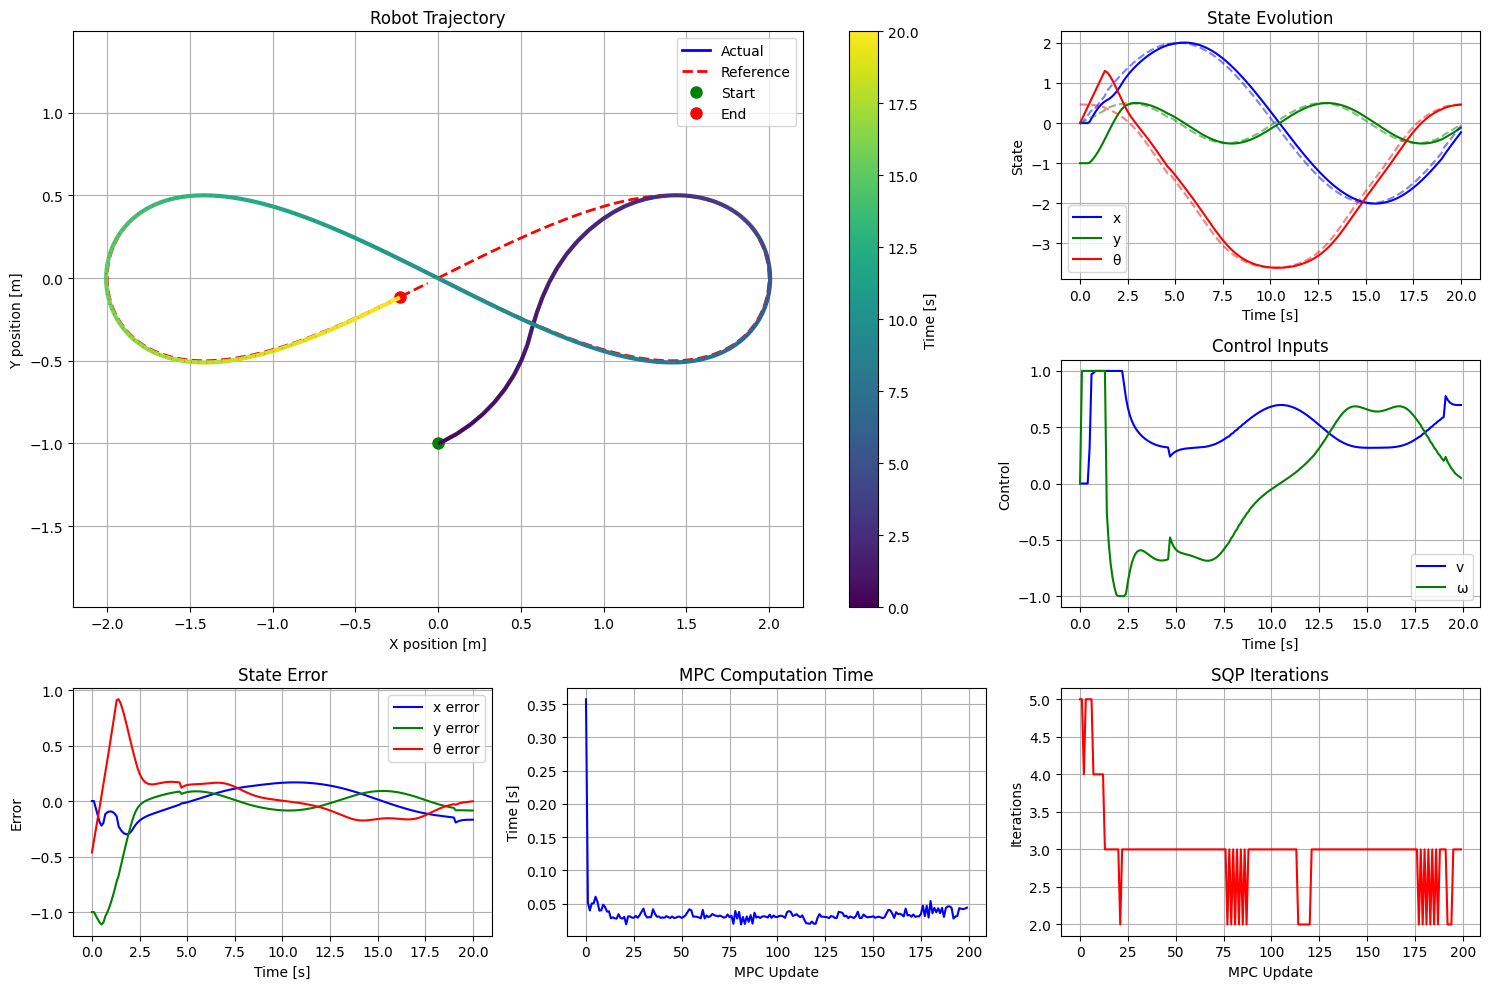

In [6]:
print("Running Unicycle MPC Demo")
results, ani = run_demo()

In [ ]:
# If in Jupyter, display the animation
try:
    from IPython.display import display
    display(HTML(ani.to_jshtml()))
except ImportError:
    print("Run this in a Jupyter notebook to see the animation.")